In [1]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [3]:
documents = WikipediaLoader(query="tennessee state information").load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

split_documents = text_splitter.split_documents(documents)

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vector_store = InMemoryVectorStore(embedding=embeddings)

vector_store.add_documents(split_documents)

['5daf449c-f53e-4956-acb9-c9c84d3d5573',
 '35d1d34f-bea8-4608-914e-d8a1d7449955',
 '8949bb8f-e901-424d-a2b5-6a738647102d',
 '37710c59-9466-484f-b163-d70fc98f0163',
 '576c489c-33ab-47b9-a5ee-b43d7597bd5b',
 '31a3a9a5-3174-47fe-9ef3-4152a3919195',
 '61ad10fa-c7a0-4cf5-982a-58235642caf9',
 'e0cfc234-6598-4820-b4fe-e24aee3e52c6',
 '12d66f1b-d238-4d4c-b8f3-f388d96eedc2',
 '15f8a55d-75e0-4fb3-bbad-1e01933d5217',
 '316966e5-3476-40db-87f9-96ecf2b0de10',
 'a88a7641-3b8b-4741-b8b1-c8fc30056164',
 'd25949b6-c578-46b6-9af5-af93038b1f32',
 'ac53000f-6afd-47c3-aa67-5677d96c98a0',
 'a4d976d7-004f-46d0-822c-a17a574ede7b',
 '9f157172-58ba-4ad5-a8ea-157febfb3c42',
 'fa19d0a4-273c-4904-86a3-7b40393f5e78',
 '2e08f4b3-2a3d-4b6f-9e17-7cc9535996eb',
 '66e095b6-77f4-483c-9855-61252d2ee297',
 '4d138338-ecc3-4856-b5dc-b6e1ee781275',
 'a2cf4bad-bc31-49f3-a4d7-f902bcd1ed32',
 'e3eec95e-482f-48ce-8b06-c10585e264e4',
 '11e778fa-d354-4520-b418-4c950c71ce4d',
 'fd5b25c6-f777-4ed8-8663-187abb768ade',
 '33727e26-017e-

In [4]:
retriever = vector_store.as_retriever()

In [5]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_tennessee_documents",
    "Search and return information about Tennessee. This tool does not return information about other States.",
)

tools = [retriever_tool]

In [6]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    description="Only use this search tool when other tools cannot provide the answer."
)

tools.append(tavily_search_tool)

In [7]:
from typing import Annotated, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [8]:
from typing import Literal

from langchain_core.messages import HumanMessage
from pydantic import BaseModel, Field


def grade_documents(state) -> Literal["generate", "rewrite"]:
    print("---CHECK RELEVANCE---")

    class grade(BaseModel):
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    llm_with_tool = llm.with_structured_output(grade)

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    input_message_text = (
        "You are a grader assessing relevance of retrieved documents to a user question. "
        f"context: {docs}"
        f"question: {question}"
        "If the documents contain keywords or semantic meaning related to the user question, grade them as relevant. "
        "Give a binary score of a 'yes' or 'no' to indicate whether the document is relevant to the question."
    )

    messages = [HumanMessage(content=input_message_text)]

    scored_result = llm_with_tool.invoke(messages)

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        print(score)
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [9]:
def agent(state):
    print("---CALL AGENT---")
    messages = state["messages"]
    llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [10]:
def rewrite(state):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    message = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent/meaning. \n
    Here is the initial question:
    \n ------ \n
    {question}
    \n ------ \n
    Formulate an improved question: """,
        )
    ]

    llm = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = llm.invoke(message)
    return {"messages": [response]}

In [11]:
from langchain_core.messages import SystemMessage


def generate(state):
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    system_prompt_message = (
        "You are an assistant for question & answering tasks. "
        "Use the following pieces of retrieved context to answer the question. "
        "If you don't know the answer, then politely say that you do not know the answer. "
        "Use a maximum of three sentences and keep answers concise. "
    )

    system_message = SystemMessage(content=system_prompt_message)

    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    messages = [system_message, HumanMessage(f"question: {question}\ncontext: {docs}")]

    response = llm.invoke(messages).content

    return {"messages": [response]}

In [12]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(AgentState)

# Add nodes to our graph
workflow.add_node("agent", agent)
tool_node = ToolNode([retriever_tool, tavily_search_tool])
workflow.add_node("tools", tool_node)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

# We start with agent
workflow.add_edge(START, "agent")

# This is where we determine if we a made a tool call
workflow.add_conditional_edges(
    "agent",
    # Did the agent call or a tool or not?
    tools_condition,
    {
        # If we did call a tool, then use the tool
        # If not, then we generate
        "tools": "tools",
        END: END,
    },
)

# If we retrieved documents, then we grade them.
# grade_documents determines where we go next based on the score: generate or rewrite
workflow.add_conditional_edges(
    "tools",
    grade_documents,
)

# If we called a tool, then we call generate.
workflow.add_edge("generate", END)
# If we need to rewrite, then we call the agent again
workflow.add_edge("rewrite", "agent")

# Compile our workflow
graph = workflow.compile()

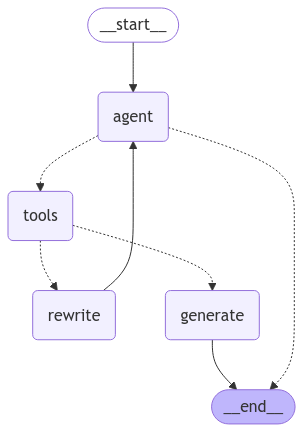

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
import pprint

input_messages = {
    "messages": [HumanMessage(content="How many people reside in Tennessee?")]
}

for output in graph.stream(input_messages):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("---")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_Qw1soUXjujqQ7ObqPa42c4YF', 'function': {'arguments': '{"query":"current population of Tennessee"}', 'name': 'retrieve_tennessee_documents'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c'}, id='run-cb9cd255-754e-4317-8f02-c1ab383f5e03-0', tool_calls=[{'name': 'retrieve_tennessee_documents', 'args': {'query': 'current population of Tennessee'}, 'id': 'call_Qw1soUXjujqQ7ObqPa42c4YF', 'type': 'tool_call'}])]}
'---'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
yes
"Output from node 'tools':"
'---'
{ 'messages': [ ToolMessage(content="According to the 2020 census, the center of population for Tennessee was located at 35.821189°N 86.332487°W\ufeff / 35.821189; -86.332487, 3.5 mi (5.6 km) southeast of Murfreesboro in Rutherford County. Th

In [15]:
input_messages = {
    "messages": [HumanMessage(content="How many people reside in Alabama?")]
}

for output in graph.stream(input_messages):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("---")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_eHOc7OiSZd9ICtwmC8S9iKCO', 'function': {'arguments': '{"query":"current population of Alabama"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c'}, id='run-412545e2-7b90-4a48-bed8-0cf3012ccf7e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current population of Alabama'}, 'id': 'call_eHOc7OiSZd9ICtwmC8S9iKCO', 'type': 'tool_call'}])]}
'---'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
yes
"Output from node 'tools':"
'---'
{ 'messages': [ ToolMessage(content='[{"url": "https://www.alabama-demographics.com/", "content": "Get the Alabama demographic data that you need. You can get the most current Alabama data from the US Census Bureau without spending 40 high-value hour

In [16]:
input_messages = {
    "messages": [HumanMessage(content="What is the tallest mountain in the US?")]
}

for output in graph.stream(input_messages):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("---")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='The tallest mountain in the United States is Denali, also known as Mount McKinley, which is located in Alaska. Denali has a peak that rises to 20,310 feet (6,190 meters) above sea level, making it the highest peak in North America.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c'}, id='run-aae3f5da-9b42-4ec2-a283-9905b69bf8f6-0')]}
'---'
